In [1]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [2]:
from utils import base_configs, deps, tr_va_te_split
from utils.helpers import rw_csv_helpers

In [3]:
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
CONFIGS = base_configs.get_base_configs()
# path to your global SHAP file

#SWITCH THE FOLLOWING ACCORDINGLY
CONFIGS["RUN_TS"] = "20251202_200541"

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Union


# ============================================================
# 1. Overall performance from proper scoring rules
# ============================================================

def compute_overall_scores_from_perf_csv(
    perf_csv: Union[str, Path],
    alpha: float = 1.0,
    beta: float = 1.0,
) -> pd.DataFrame:
    """
    Read performance CSV and compute combined proper loss and overall score.

    L_combo_j = alpha * logloss_j + beta * brier_j
    S_j       = - L_combo_j

    Parameters
    ----------
    perf_csv : str or Path
        Path to CSV file with at least ["model", "logloss", "brier"].
    alpha : float
        Non-negative weight for logloss.
    beta : float
        Non-negative weight for brier.

    Returns
    -------
    df : DataFrame
        Original performance table with added columns:
          - "L_combo"       : combined loss
          - "overall_score" : S_j = -L_combo
    """
    perf_csv = Path(perf_csv)
    df = pd.read_csv(perf_csv)

    if "logloss" not in df.columns or "brier" not in df.columns:
        raise ValueError("Performance CSV must contain 'logloss' and 'brier' columns.")

    if alpha < 0 or beta < 0 or (alpha == 0 and beta == 0):
        raise ValueError("Require alpha, beta ≥ 0 and not both zero.")

    L_combo = alpha * df["logloss"].to_numpy() + beta * df["brier"].to_numpy()
    df["L_combo"] = L_combo
    df["overall_score"] = -L_combo  # higher = better

    return df


# ============================================================
# 2. BMA-style weights from overall scores
# ============================================================

def softmax_weights(scores: np.ndarray, lambda_: float = 1.0) -> np.ndarray:
    """
    Compute softmax weights:

        w_j ∝ exp(lambda_ * scores_j)

    Parameters
    ----------
    scores : array-like, shape (M,)
        Overall performance scores S_j (higher = better).
    lambda_ : float
        Inverse temperature parameter; lambda_ > 0.

    Returns
    -------
    w : ndarray, shape (M,)
        Normalized weights summing to 1.
    """
    scores = np.asarray(scores, dtype=float)
    if scores.ndim != 1:
        raise ValueError("scores must be a 1D array.")
    if lambda_ <= 0:
        raise ValueError("lambda_ must be > 0.")

    x = lambda_ * scores
    x = x - np.max(x)  # numerical stability
    w_raw = np.exp(x)
    w = w_raw / w_raw.sum()
    return w


def add_wfia_weights(
    perf_df: pd.DataFrame,
    score_col: str = "overall_score",
    lambda_: float = 1.0,
    weight_col: str = "wfia_weight",
) -> pd.DataFrame:
    """
    Given a performance DataFrame with a score column S_j,
    add BMA-style WFIA weights:

        w_j = softmax(lambda_ * S_j)

    Parameters
    ----------
    perf_df : DataFrame
        Must contain column score_col.
    score_col : str
        Name of column containing S_j.
    lambda_ : float
        Inverse temperature parameter for softmax.
    weight_col : str
        Name of column to store weights.

    Returns
    -------
    df_out : DataFrame
        Copy of perf_df with an additional weight_col column.
    """
    if score_col not in perf_df.columns:
        raise ValueError(f"'{score_col}' not found in performance DataFrame.")

    scores = perf_df[score_col].to_numpy()
    w = softmax_weights(scores, lambda_=lambda_)

    df_out = perf_df.copy()
    df_out[weight_col] = w
    return df_out


# ============================================================
# 3. WFIA from global SHAP *_shap_norm columns
# ============================================================

def compute_wfia_from_global_shap_norm(
    perf_df: pd.DataFrame,
    shap_csv: Union[str, Path],
    shap_suffix: str = "_shap_norm",
    weight_col: str = "wfia_weight",
    feature_col: str = "feature",
) -> pd.DataFrame:
    """
    Compute WFIA feature importance from a global SHAP file with *_shap_norm columns.

    Assumptions
    ----------
    - shap_csv has one row per feature.
    - There is a column giving feature names (default 'feature').
    - For each model name m in perf_df['model'], there is a column f"{m}{shap_suffix}",
      e.g. 'lr_shap_norm', 'rf_shap_norm', ...

    WFIA importance for feature f is:

        WFIA(f) = Σ_j w_j * Φ_f^(j),

    where Φ_f^(j) is the global normalized SHAP importance for feature f
    under model j (column m+shap_suffix) and w_j is the weight from perf_df[weight_col].

    Parameters
    ----------
    perf_df : DataFrame
        Performance table with columns:
          - 'model'
          - weight_col (e.g. 'wfia_weight').
    shap_csv : str or Path
        Path to global SHAP CSV with columns like 'lr_shap_norm', 'rf_shap_norm', ...
    shap_suffix : str
        Suffix appended to model name to get the SHAP column, e.g. '_shap_norm'.
    weight_col : str
        Name of the weight column in perf_df.
    feature_col : str
        Name of the feature-name column in shap_csv (if present).

    Returns
    -------
    gdf_out : DataFrame
        Global SHAP table with an additional column 'WFIA_importance'.
    """
    shap_csv = Path(shap_csv)
    gdf = pd.read_csv(shap_csv)

    # Determine models and corresponding SHAP columns
    models = perf_df["model"].astype(str).tolist()
    model_to_col = {}
    for m in models:
        col = f"{m}{shap_suffix}"
        if col in gdf.columns:
            model_to_col[m] = col

    if not model_to_col:
        raise ValueError(
            "No matching '*_shap_norm' columns found in SHAP file for the models "
            f"listed in perf_df. Checked suffix '{shap_suffix}'."
        )

    used_models = list(model_to_col.keys())
    shap_cols = [model_to_col[m] for m in used_models]

    # Align weights with the used models
    weights_series = (
        perf_df.set_index("model")
        .loc[used_models][weight_col]
    )
    w = weights_series.to_numpy()  # shape: (M_used,)

    if not np.isclose(w.sum(), 1.0):
        w = w / w.sum()

    # Extract matrix of SHAP norms: features x models
    shap_mat = gdf[shap_cols].to_numpy()  # shape: (n_features, M_used)

    # WFIA importance per feature: dot product across models
    # WFIA(f) = Σ_j w_j * Φ_f^(j)
    wfia_vals = shap_mat @ w  # shape: (n_features,)

    gdf_out = gdf.copy()
    gdf_out["WFIA_importance"] = wfia_vals

    # Optional: sort features by WFIA importance (descending)
    if feature_col in gdf_out.columns:
        gdf_out = gdf_out.sort_values("WFIA_importance", ascending=False)

    return gdf_out


# ============================================================
# 4. End-to-end example
# ============================================================

if __name__ == "__main__":
    # ----------------------------------------------------------------
    # 4.1. Performance CSV -> overall scores and WFIA weights
    # ----------------------------------------------------------------
    perf_csv_path = f"op/all_test_report.csv"  # adjust to your file

    # Step 1: overall scores from combined proper loss
    #   alpha, beta control the relative weight of logloss vs brier
    perf_df = compute_overall_scores_from_perf_csv(
        perf_csv=perf_csv_path,
        alpha=1.0,   # weight for logloss
        beta=1.0,    # weight for brier
    )

    # Step 2: WFIA/BMA-style weights from overall_score
    perf_df = add_wfia_weights(
        perf_df,
        score_col="overall_score",
        lambda_=1.0,        # inverse temperature; tune if desired
        weight_col="wfia_weight",
    )

    out_perf_path = Path(perf_csv_path).with_name(
        f"{Path(perf_csv_path).stem}_with_scores_weights.csv"
    )
    perf_df.to_csv(out_perf_path, index=False)

    print("=== Performance + WFIA weights ===")
    print(perf_df[["model", "logloss", "brier", "overall_score", "wfia_weight"]])

    # ----------------------------------------------------------------
    # 4.2. WFIA from global SHAP *_shap_norm columns
    # ----------------------------------------------------------------
    # Example for your path:
    shap_score_file = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}.csv"
    # shap_score_file = f"op/tr_va_te_metric_shap_20251202_200541/global_shap_20251202_200541.csv"

    gdf_wfia = compute_wfia_from_global_shap_norm(
        perf_df=perf_df,
        shap_csv=shap_score_file,
        shap_suffix="_shap_norm",     # columns like 'lr_shap_norm', 'rf_shap_norm', ...
        weight_col="wfia_weight",
        feature_col="feature",        # adapt if your feature column has a different name
    )

    out_wfia_path = Path(shap_score_file).with_name(
        f"{Path(shap_score_file).stem}_with_WFIA.csv"
    )
    gdf_wfia.to_csv(out_wfia_path, index=False)

    print("\n=== WFIA feature importance (from *_shap_norm columns) ===")
    print(gdf_wfia[[c for c in gdf_wfia.columns if c.endswith("_shap_norm")] +
                   ["WFIA_importance"]].head())
    print("WFIA SHAP table saved to:", out_wfia_path)


=== Performance + WFIA weights ===
    model   logloss     brier  overall_score  wfia_weight
0      lr  0.255621  0.073360      -0.328981     0.172431
1      rf  0.301840  0.076559      -0.378400     0.164117
2     xgb  0.266577  0.075583      -0.342159     0.170174
3   xlstm  0.317639  0.079404      -0.397043     0.161086
4  tabnet  0.278690  0.073639      -0.352328     0.168452
5     mlp  0.304104  0.076605      -0.380709     0.163739

=== WFIA feature importance (from *_shap_norm columns) ===
    lr_shap_norm  rf_shap_norm  mlp_shap_norm  xgb_shap_norm  xlstm_shap_norm  \
22      0.147429      0.174860       0.141390       0.177411         0.168044   
16      0.161104      0.136236       0.179189       0.112532         0.134070   
17      0.151632      0.105992       0.169422       0.104184         0.130983   
21      0.114479      0.066055       0.101797       0.084878         0.110668   
9       0.044051      0.107926       0.046920       0.141667         0.029308   

    WFIA_imp

Top features by WFIA_importance:
                          feature  WFIA_importance
0                 smokeStat_Never         0.161783
1          GeneralHealth_VeryGood         0.144580
2              GeneralHealth_Good         0.132417
3                smokeStat_Former         0.095629
4                             Age         0.074344
5         GeneralHealth_Excellent         0.072420
6              GeneralHealth_Fair         0.052187
7               smokeStat_Current         0.045340
8                  eCigUse_Former         0.025856
9                   eCigUse_Never         0.024569
10             AverageTimeSitting         0.017745
11           MedConditions_HighBP         0.016592
12              AverageSleepNight         0.016112
13               AvgDrinksPerWeek         0.015717
14                            BMI         0.014088
15  WeeklyMinutesModerateExercise         0.013797
16                eCigUse_Current         0.011827
17                           PHQ4         0.01095

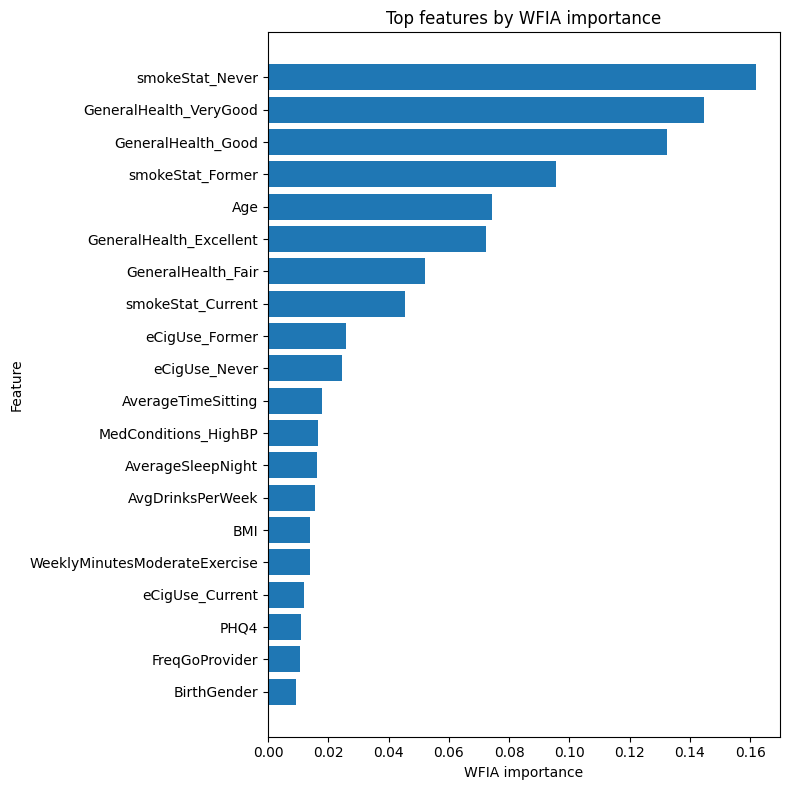

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------------------------------------------
# 1. Read WFIA output and sort by WFIA_importance
# ----------------------------------------------------------------

# This must match what you used earlier
shap_score_file = f"op/tr_va_te_metric_shap_{CONFIGS['RUN_TS']}/global_shap_{CONFIGS['RUN_TS']}.csv"

out_wfia_path = Path(shap_score_file).with_name(
    f"{Path(shap_score_file).stem}_with_WFIA.csv"
)

# Read the file with WFIA_importance
wfia_df = pd.read_csv(out_wfia_path)

# If your feature column has a different name, change it here
feature_col = "feature"

# Sort by WFIA_importance descending
wfia_sorted = wfia_df.sort_values("WFIA_importance", ascending=False)

# Optionally restrict to top K features for plotting
TOP_K = 20
wfia_top = wfia_sorted.head(TOP_K)

print("Top features by WFIA_importance:")
print(wfia_top[[feature_col, "WFIA_importance"]])

# ----------------------------------------------------------------
# 2. Plot WFIA_importance (top K) as a horizontal bar chart
# ----------------------------------------------------------------

plt.figure(figsize=(8, 0.4 * len(wfia_top)))  # height scales with number of features

plt.barh(
    wfia_top[feature_col],
    wfia_top["WFIA_importance"],
)

plt.gca().invert_yaxis()  # highest at the top
plt.xlabel("WFIA importance")
plt.ylabel("Feature")
plt.title("Top features by WFIA importance")

plt.tight_layout()
plt.show()


Top features by WFIA_importance:
                          feature  WFIA_importance
0                 smokeStat_Never         0.161783
1          GeneralHealth_VeryGood         0.144580
2              GeneralHealth_Good         0.132417
3                smokeStat_Former         0.095629
4                             Age         0.074344
5         GeneralHealth_Excellent         0.072420
6              GeneralHealth_Fair         0.052187
7               smokeStat_Current         0.045340
8                  eCigUse_Former         0.025856
9                   eCigUse_Never         0.024569
10             AverageTimeSitting         0.017745
11           MedConditions_HighBP         0.016592
12              AverageSleepNight         0.016112
13               AvgDrinksPerWeek         0.015717
14                            BMI         0.014088
15  WeeklyMinutesModerateExercise         0.013797
16                eCigUse_Current         0.011827
17                           PHQ4         0.01095

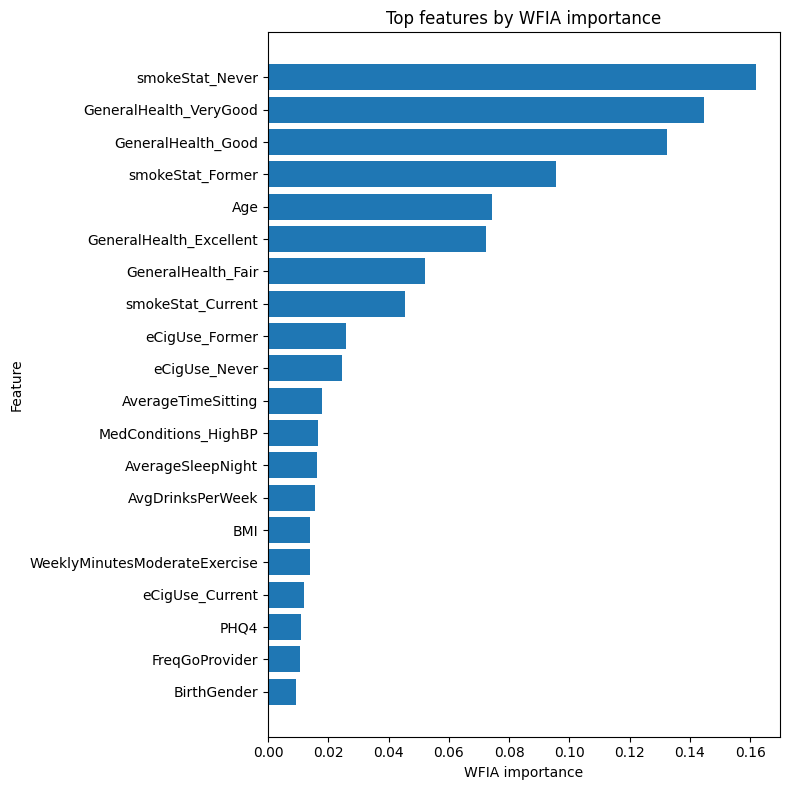

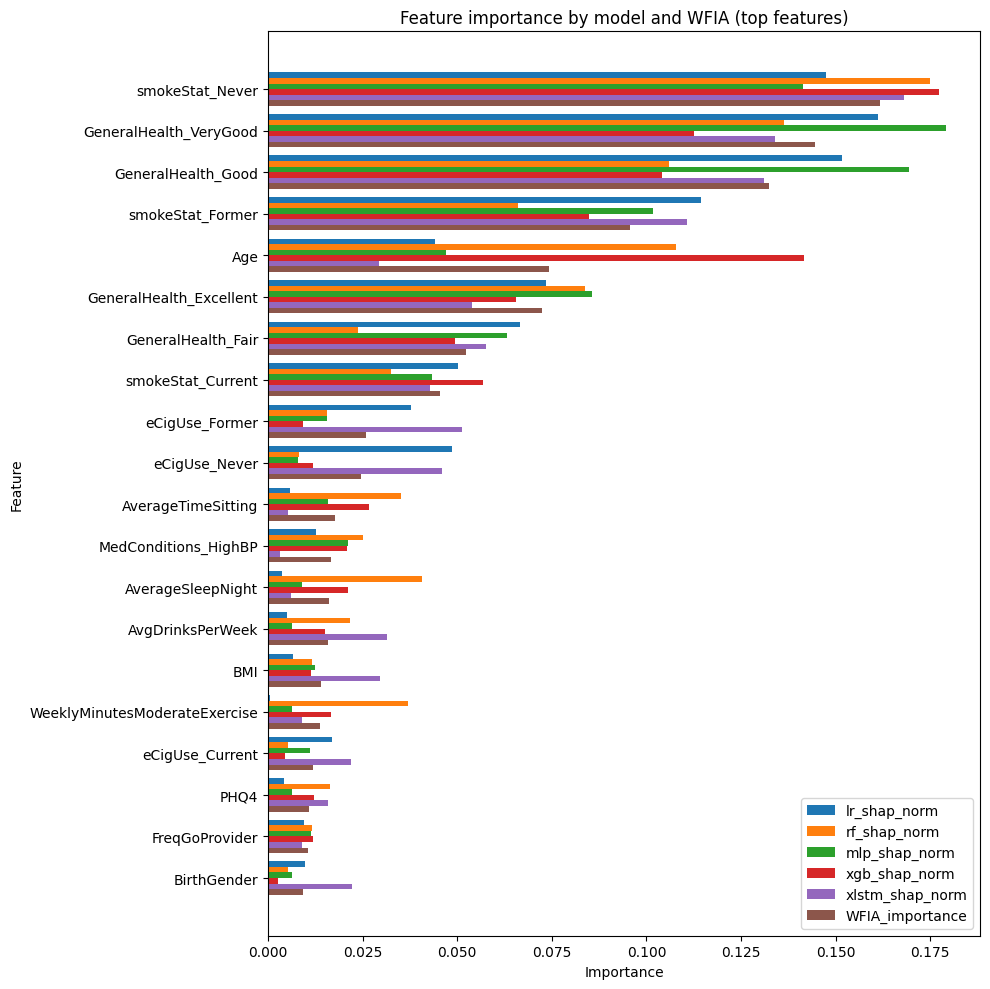

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================================
# 1. Read WFIA file and sort by WFIA_importance
# ============================================================

# Original SHAP file (as used before)
shap_score_file = "op/tr_va_te_metric_shap_20251202_200541/global_shap_20251202_200541.csv"

# File that contains WFIA_importance (created earlier)
out_wfia_path = Path(shap_score_file).with_name(
    f"{Path(shap_score_file).stem}_with_WFIA.csv"
)

# Read WFIA file
wfia_df = pd.read_csv(out_wfia_path)

# Name of column containing feature names (change if different)
feature_col = "feature"

# Sort features by WFIA_importance DESCENDING
wfia_sorted = wfia_df.sort_values("WFIA_importance", ascending=False)

# Number of top features to plot
TOP_K = 20
wfia_top = wfia_sorted.head(TOP_K).reset_index(drop=True)

print("Top features by WFIA_importance:")
print(wfia_top[[feature_col, "WFIA_importance"]])

# Identify model-specific normalized SHAP columns: lr_shap_norm, rf_shap_norm, ...
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]

# ============================================================
# 2. WFIA_importance (top K) as horizontal bar chart
# ============================================================

plt.figure(figsize=(8, 0.4 * len(wfia_top)))

plt.barh(
    wfia_top[feature_col],
    wfia_top["WFIA_importance"],
)

# Highest WFIA at the top
plt.gca().invert_yaxis()

plt.xlabel("WFIA importance")
plt.ylabel("Feature")
plt.title("Top features by WFIA importance")

plt.tight_layout()
plt.show()

# ============================================================
# 3. Grouped horizontal bar chart: WFIA vs each model's *_shap_norm
# ============================================================

# Build comparison table: feature, WFIA_importance, and all *_shap_norm columns
comp_cols = [feature_col, "WFIA_importance"] + shap_norm_cols
comp_df = wfia_top[comp_cols].copy()

features = comp_df[feature_col].tolist()
n_features = len(features)

# "Sources" = each model column + WFIA_importance
sources = shap_norm_cols + ["WFIA_importance"]
n_sources = len(sources)

# Positions on y-axis (one group per feature)
y = np.arange(n_features)
bar_height = 0.8 / n_sources  # total thickness ≈ 0.8

plt.figure(figsize=(10, 0.5 * n_features))

for i, src in enumerate(sources):
    vals = comp_df[src].to_numpy()

    # Center the group around y, shift each source by i*bar_height
    offset = (i - n_sources / 2) * bar_height + bar_height / 2
    plt.barh(y + offset, vals, height=bar_height, label=src)

plt.yticks(y, features)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance by model and WFIA (top features)")

# Ensure highest WFIA feature is at the TOP
plt.gca().invert_yaxis()

plt.legend(loc="best")
plt.tight_layout()
plt.show()


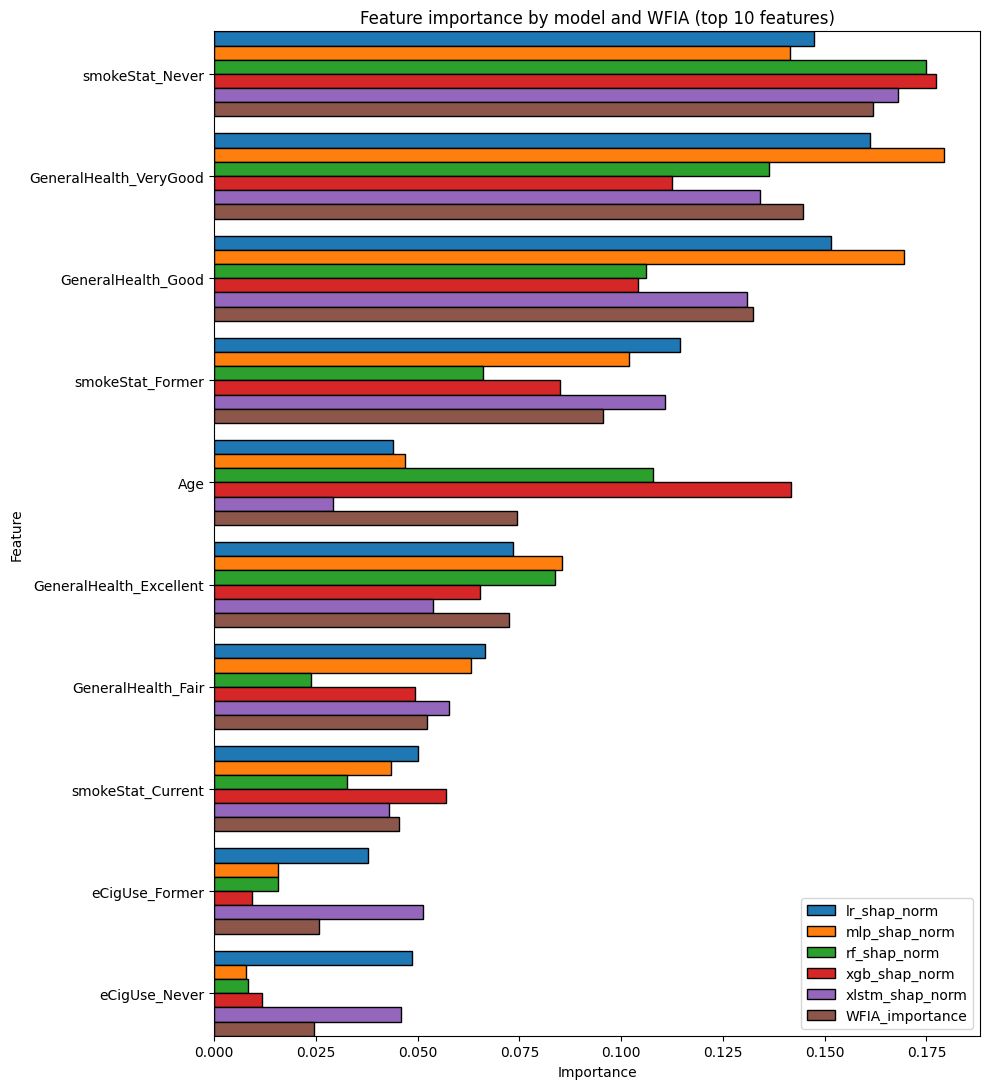

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - one column per model: 'lr_shap_norm', 'rf_shap_norm', ... '*_shap_norm'

feature_col = "feature"
top_k = 10  # how many top features to plot

# -------------------------------------------------------------------
# Select top-k features by WFIA_importance (highest first)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
# optional: sort columns for consistent legend order
shap_norm_cols = sorted(shap_norm_cols)

# -------------------------------------------------------------------
# Build comparison table
# -------------------------------------------------------------------
comp_cols = [feature_col, "WFIA_importance"] + shap_norm_cols
comp_df = wfia_top[comp_cols].copy()

features = comp_df[feature_col].tolist()
n_features = len(features)

# Sources = each model column + WFIA_importance
sources = shap_norm_cols + ["WFIA_importance"]
n_sources = len(sources)

# -------------------------------------------------------------------
# Vertical layout parameters
# -------------------------------------------------------------------
group_height = 2.5        # total vertical span reserved per feature group
gap = 0.5                 # extra gap between feature groups
bar_height = group_height / n_sources

# Center positions for each feature along y-axis, spaced by (group_height + gap)
# index 0 = best feature (highest WFIA)
y_centers = np.arange(n_features) * (group_height + gap)

# Distinct colors for each source using tab10
cmap = plt.get_cmap("tab10")
colors = [cmap(i % 10) for i in range(n_sources)]

# Figure height scales with number of features
bar_width_ctrl = 1.1 # The bar_width_ctrl will control the how thick each bar should be.
plt.figure(figsize=(10, bar_width_ctrl * n_features))

# -------------------------------------------------------------------
# Draw grouped horizontal bars
# -------------------------------------------------------------------
for i, (src, color) in enumerate(zip(sources, colors)):
    vals = comp_df[src].to_numpy()

    # Shift each source within its group's vertical band
    offset = (i - n_sources / 2) * bar_height + bar_height / 2
    plt.barh(
        y_centers + offset,
        vals,
        height=bar_height,
        label=src,
        color=color,
        edgecolor="black",
    )

# Put feature names at the group centers
plt.yticks(y_centers, features)

# -------------------------------------------------------------------
# Remove top/bottom whitespace and keep highest WFIA at the top
# -------------------------------------------------------------------
ax = plt.gca()

# Outer edges of first and last feature groups
y_min = -group_height / 2                       # above first group's center (0)
y_max = y_centers[-1] + group_height / 2        # below last group's center

# Set limits *reversed* so that y=0 is at the top and there is no extra padding
ax.set_ylim(y_max, y_min)
ax.margins(y=0)  # no automatic vertical margins

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Feature importance by model and WFIA (top {n_features} features)")

plt.legend(loc="best")
plt.tight_layout()
plt.show()


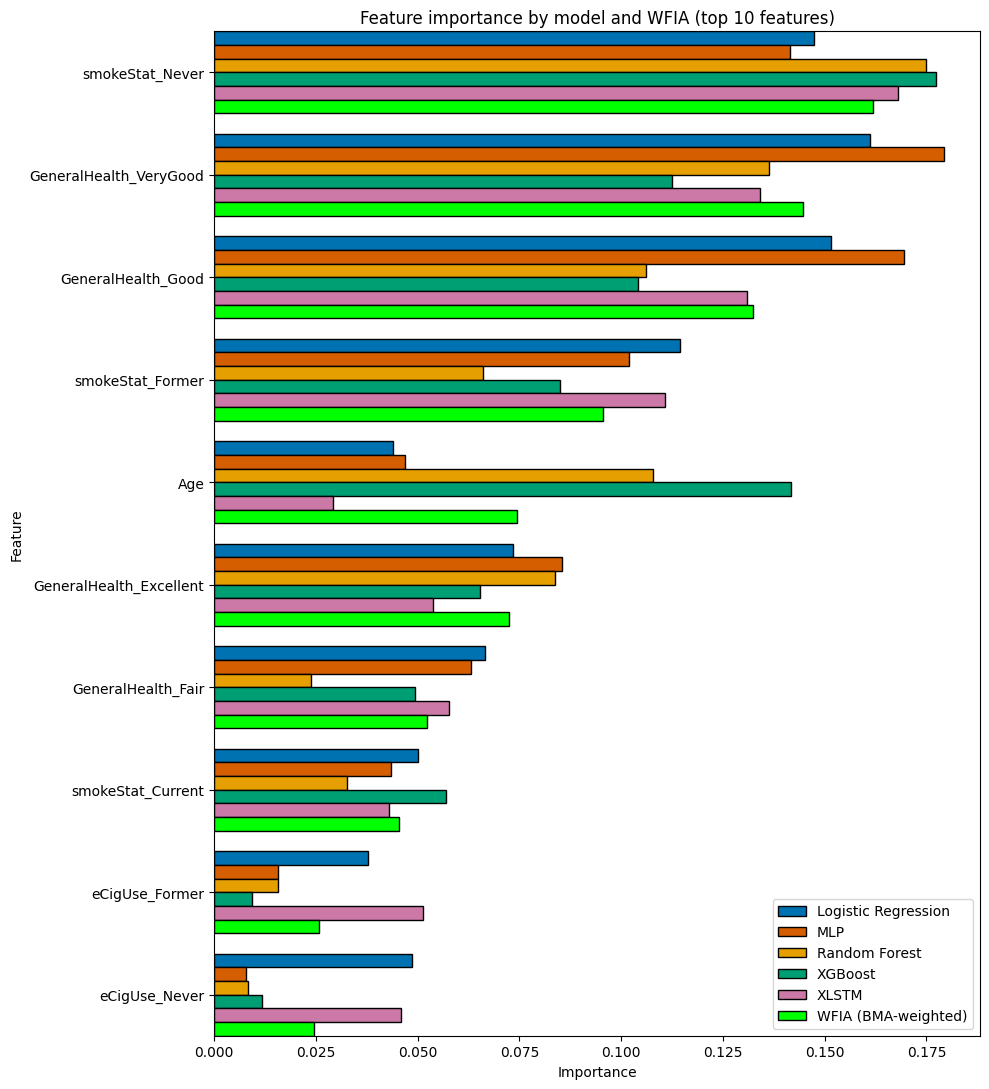

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - one column per model: 'lr_shap_norm', 'rf_shap_norm', ... '*_shap_norm'

feature_col = "feature"
top_k = 10  # how many top features to plot

# -------------------------------------------------------------------
# Select top-k features by WFIA_importance (highest first)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
shap_norm_cols = sorted(shap_norm_cols)  # optional, for stable ordering

# -------------------------------------------------------------------
# Custom legend names and colors
# -------------------------------------------------------------------
# Map column names to human-readable legend labels
# Highly distinguishable colors (hex)
palette = {
    "blue":         "#0072B2",  # deep blue
    "orange":       "#E69F00",  # orange
    "teal":         "#009E73",  # teal/green
    "vermillion":   "#D55E00",  # reddish
    "purple":       "#CC79A7",  # reddish purple
    "yellow":       "#F0E442",  # yellow
    "skyblue":      "#56B4E9",  # sky blue
    "bright_green": "#00FF00",  # bright green for WFIA
}
legend_labels = {
    "lr_shap_norm":  "Logistic Regression",
    "rf_shap_norm":  "Random Forest",
    "xgb_shap_norm": "XGBoost",
    "mlp_shap_norm": "MLP",
    "xlstm_shap_norm": "XLSTM",
    "tabnet_shap_norm": "TabNet",
    "WFIA_importance": "WFIA (BMA-weighted)",
}

# Map column names to colors (any matplotlib color spec)
color_map = {
    "lr_shap_norm":    palette["blue"],
    "rf_shap_norm":    palette["orange"],
    "xgb_shap_norm":   palette["teal"],
    "mlp_shap_norm":   palette["vermillion"],
    "xlstm_shap_norm": palette["purple"],
    "tabnet_shap_norm":palette["skyblue"],
    "WFIA_importance": palette["bright_green"],  # WFIA in bright green
}

# If a source is not in color_map, fall back to a colormap
fallback_cmap = plt.get_cmap("tab10")

# -------------------------------------------------------------------
# Build comparison table
# -------------------------------------------------------------------
comp_cols = [feature_col, "WFIA_importance"] + shap_norm_cols
comp_df = wfia_top[comp_cols].copy()

features = comp_df[feature_col].tolist()
n_features = len(features)

# Sources = each model column + WFIA_importance
sources = shap_norm_cols + ["WFIA_importance"]
n_sources = len(sources)

# -------------------------------------------------------------------
# Vertical layout parameters
# -------------------------------------------------------------------
group_height = 1.6        # total vertical span reserved per feature group
gap = 0.4                 # extra gap between feature groups
bar_height = group_height / n_sources

# Center positions for each feature along y-axis, spaced by (group_height + gap)
# index 0 = best feature (highest WFIA)
y_centers = np.arange(n_features) * (group_height + gap)

# Figure height scales with number of features
bar_width_ctrl = 1.1 # The bar_width_ctrl will control the how thick each bar should be.
plt.figure(figsize=(10, bar_width_ctrl * n_features))

# -------------------------------------------------------------------
# Draw grouped horizontal bars
# -------------------------------------------------------------------
for i, src in enumerate(sources):
    vals = comp_df[src].to_numpy()

    # Vertical offset of this source within each feature's band
    offset = (i - n_sources / 2) * bar_height + bar_height / 2

    # Pick color and label
    color = color_map.get(src, fallback_cmap(i % 10))
    label = legend_labels.get(src, src)

    plt.barh(
        y_centers + offset,
        vals,
        height=bar_height,
        label=label,
        color=color,
        edgecolor="black",
    )

# Put feature names at the group centers
plt.yticks(y_centers, features)

# -------------------------------------------------------------------
# Remove top/bottom whitespace and keep highest WFIA at the top
# -------------------------------------------------------------------
ax = plt.gca()

# Outer edges of first and last feature groups
y_min = -group_height / 2                       # just above first group center (0)
y_max = y_centers[-1] + group_height / 2        # just below last group center

# Reverse limits so 0 (best feature) is at the top, no padding
ax.set_ylim(y_max, y_min)
ax.margins(y=0)  # disable automatic vertical margins

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Feature importance by model and WFIA (top {n_features} features)")

plt.legend(loc="best")
plt.tight_layout()
plt.show()


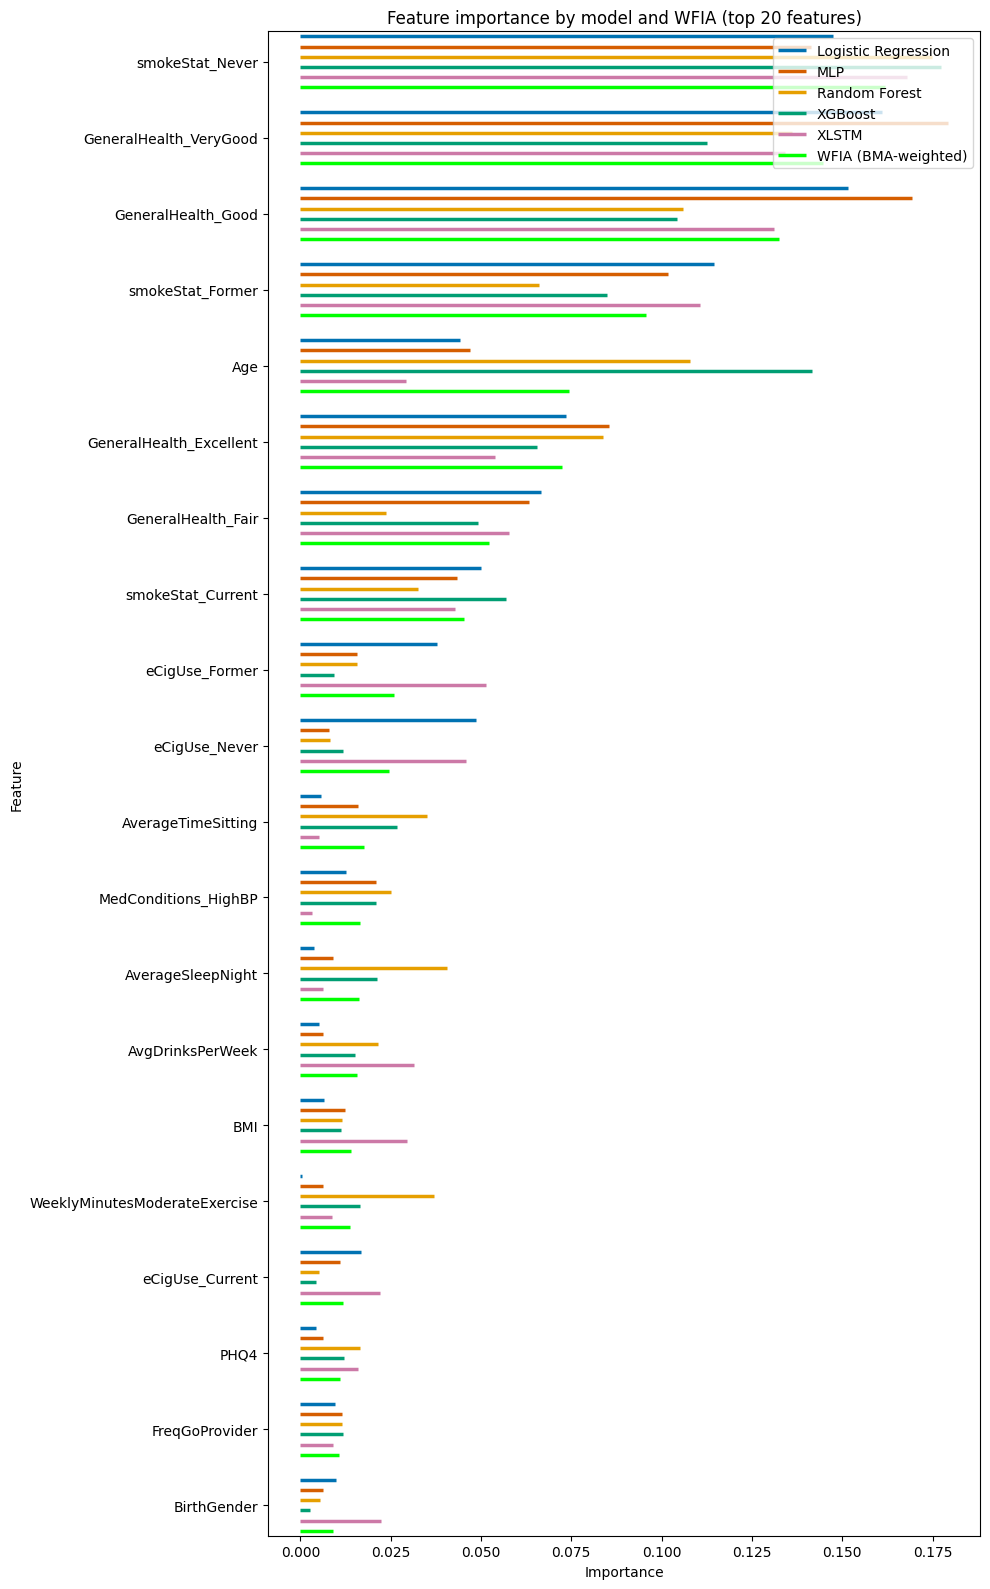

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - one column per model: 'lr_shap_norm', 'rf_shap_norm', ... '*_shap_norm'

feature_col = "feature"
top_k = 20  # how many top features to plot

# -------------------------------------------------------------------
# Select top-k features by WFIA_importance (highest first)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
shap_norm_cols = sorted(shap_norm_cols)  # optional, for stable ordering

# -------------------------------------------------------------------
# Custom legend names and colors
# -------------------------------------------------------------------
palette = {
    "blue":         "#0072B2",  # deep blue
    "orange":       "#E69F00",  # orange
    "teal":         "#009E73",  # teal/green
    "vermillion":   "#D55E00",  # reddish
    "purple":       "#CC79A7",  # reddish purple
    "yellow":       "#F0E442",  # yellow
    "skyblue":      "#56B4E9",  # sky blue
    "bright_green": "#00FF00",  # bright green for WFIA
}

legend_labels = {
    "lr_shap_norm":     "Logistic Regression",
    "rf_shap_norm":     "Random Forest",
    "xgb_shap_norm":    "XGBoost",
    "mlp_shap_norm":    "MLP",
    "xlstm_shap_norm":  "XLSTM",
    "tabnet_shap_norm": "TabNet",
    "WFIA_importance":  "WFIA (BMA-weighted)",
}

color_map = {
    "lr_shap_norm":     palette["blue"],
    "rf_shap_norm":     palette["orange"],
    "xgb_shap_norm":    palette["teal"],
    "mlp_shap_norm":    palette["vermillion"],
    "xlstm_shap_norm":  palette["purple"],
    "tabnet_shap_norm": palette["skyblue"],
    "WFIA_importance":  palette["bright_green"],  # WFIA in bright green
}

fallback_cmap = plt.get_cmap("tab10")

# -------------------------------------------------------------------
# Build comparison table
# -------------------------------------------------------------------
comp_cols = [feature_col, "WFIA_importance"] + shap_norm_cols
comp_df = wfia_top[comp_cols].copy()

features = comp_df[feature_col].tolist()
n_features = len(features)

# Sources = each model column + WFIA_importance
sources = shap_norm_cols + ["WFIA_importance"]
n_sources = len(sources)

# -------------------------------------------------------------------
# Vertical layout parameters
# -------------------------------------------------------------------
group_height = 1.6        # total vertical span reserved per feature group
gap = 0.4                 # extra gap between feature groups
line_band_height = group_height / n_sources

# Center positions for each feature along y-axis, spaced by (group_height + gap)
# index 0 = best feature (highest WFIA)
y_centers = np.arange(n_features) * (group_height + gap)

plt.figure(figsize=(10, 0.8 * n_features))

# -------------------------------------------------------------------
# Draw grouped horizontal lines (no bars)
# -------------------------------------------------------------------
for i, src in enumerate(sources):
    vals = comp_df[src].to_numpy()

    # Vertical offset of this source within each feature's band
    offset = (i - n_sources / 2) * line_band_height + line_band_height / 2
    y_positions = y_centers + offset

    color = color_map.get(src, fallback_cmap(i % 10))
    label = legend_labels.get(src, src)

    # Horizontal lines from 0 to value
    plt.hlines(
        y=y_positions,
        xmin=0,
        xmax=vals,
        colors=color,
        linewidth=2.5,
        label=label,
    )

# Put feature names at the group centers
plt.yticks(y_centers, features)

# -------------------------------------------------------------------
# Remove top/bottom whitespace and keep highest WFIA at the top
# -------------------------------------------------------------------
ax = plt.gca()

# Outer edges of first and last feature groups
y_min = -group_height / 2                       # just above first group center (0)
y_max = y_centers[-1] + group_height / 2        # just below last group center

# Reverse limits so 0 (best feature) is at the top, no padding
ax.set_ylim(y_max, y_min)
ax.margins(y=0)  # disable automatic vertical margins

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Feature importance by model and WFIA (top {n_features} features)")

plt.legend(loc="best")
plt.tight_layout()
plt.show()


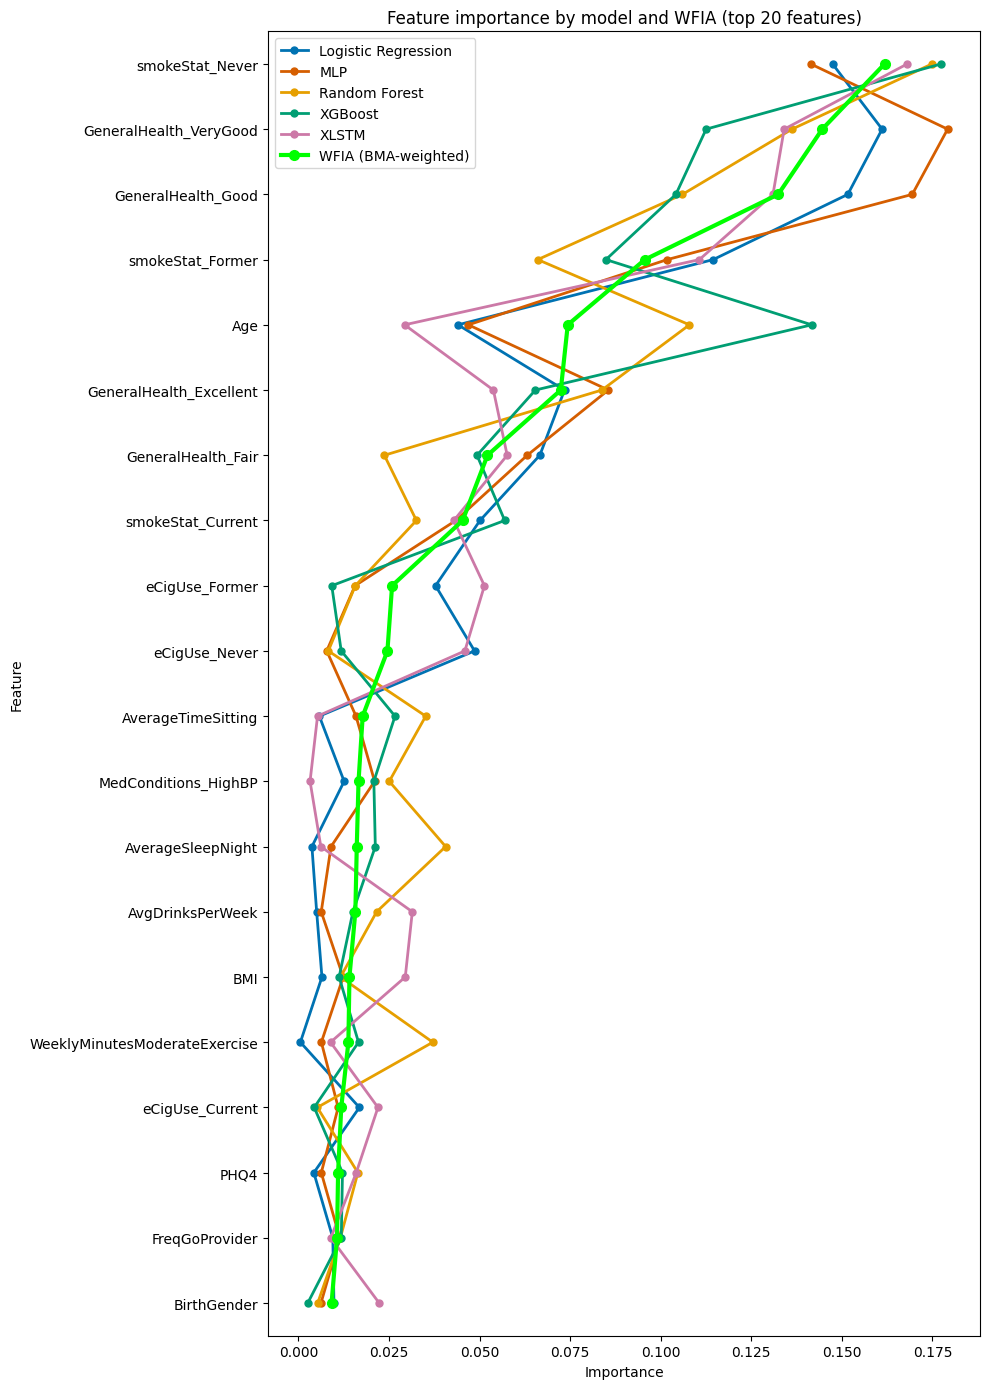

Saved WFIA feature-importance plot to: op/fin_op/feature_importance_differences0_top20.png


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - one column per model: 'lr_shap_norm', 'rf_shap_norm', ... '*_shap_norm'

feature_col = "feature"
top_k = 20  # how many top features to plot

# -------------------------------------------------------------------
# 0. Ensure output directory exists
# -------------------------------------------------------------------
out_dir = "op/fin_op"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"feature_importance_differences0_top{top_k}.png")

# -------------------------------------------------------------------
# 1. Select top-k features by WFIA_importance (highest first)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
shap_norm_cols = sorted(shap_norm_cols)  # stable ordering

# -------------------------------------------------------------------
# 2. Legend labels and colors
# -------------------------------------------------------------------
palette = {
    "blue":         "#0072B2",  # deep blue
    "orange":       "#E69F00",  # orange
    "teal":         "#009E73",  # teal/green
    "vermillion":   "#D55E00",  # reddish
    "purple":       "#CC79A7",  # reddish purple
    "yellow":       "#F0E442",  # yellow
    "skyblue":      "#56B4E9",  # sky blue
    "bright_green": "#00FF00",  # bright green for WFIA
}

legend_labels = {
    "lr_shap_norm":     "Logistic Regression",
    "rf_shap_norm":     "Random Forest",
    "xgb_shap_norm":    "XGBoost",
    "mlp_shap_norm":    "MLP",
    "xlstm_shap_norm":  "XLSTM",
    "tabnet_shap_norm": "TabNet",
    "WFIA_importance":  "WFIA (BMA-weighted)",
}

color_map = {
    "lr_shap_norm":     palette["blue"],
    "rf_shap_norm":     palette["orange"],
    "xgb_shap_norm":    palette["teal"],
    "mlp_shap_norm":    palette["vermillion"],
    "xlstm_shap_norm":  palette["purple"],
    "tabnet_shap_norm": palette["skyblue"],
    "WFIA_importance":  palette["bright_green"],  # WFIA in bright green
}

fallback_cmap = plt.get_cmap("tab10")

# -------------------------------------------------------------------
# 3. Build data for plotting
# -------------------------------------------------------------------
features = wfia_top[feature_col].tolist()
n_features = len(features)

# y positions: 0 .. n_features-1 (0 = highest WFIA)
y = np.arange(n_features)

# Sources = each model column + WFIA
sources = shap_norm_cols + ["WFIA_importance"]
n_sources = len(sources)

plt.figure(figsize=(10, 0.6 * n_features + 2))

# -------------------------------------------------------------------
# 4. Plot one line per model (and WFIA), connecting all features
# -------------------------------------------------------------------
for i, src in enumerate(sources):
    vals = wfia_top[src].to_numpy()

    color = color_map.get(src, fallback_cmap(i % 10))
    label = legend_labels.get(src, src)

    # Make WFIA line a bit more prominent
    if src == "WFIA_importance":
        lw = 3.0
        ms = 7
        z = 3
    else:
        lw = 2.0
        ms = 5
        z = 2

    plt.plot(
        vals,
        y,
        marker="o",
        linewidth=lw,
        markersize=ms,
        color=color,
        label=label,
        zorder=z,
    )

# -------------------------------------------------------------------
# 5. Axis formatting: features on y, highest WFIA at top, no vertical whitespace
# -------------------------------------------------------------------
plt.yticks(y, features)

ax = plt.gca()
# Set y-limits so first and last rows are at the frame, and invert so 0 is on top
ax.set_ylim(n_features - 0.5, -0.5)
ax.margins(y=0)  # no extra vertical padding

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Feature importance by model and WFIA (top {n_features} features)")

plt.legend(loc="best")
plt.tight_layout()

# -------------------------------------------------------------------
# 6. Save and show
# -------------------------------------------------------------------
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved WFIA feature-importance plot to: {out_path}")


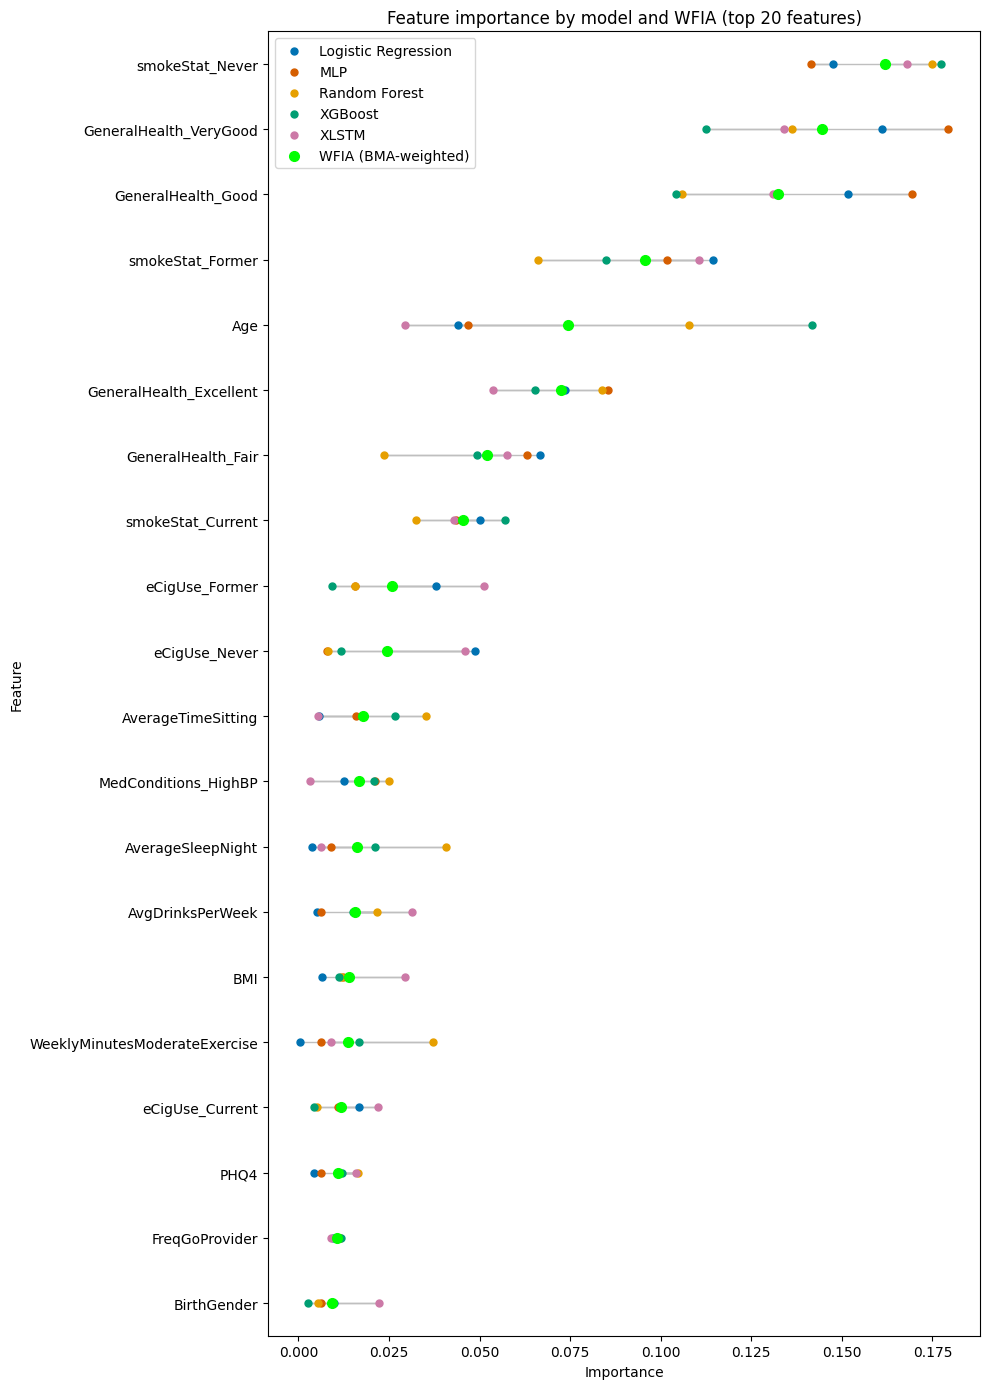

Saved WFIA feature importance plot to: op/fin_op/feature_importance_differences1_top20.png


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - one column per model: 'lr_shap_norm', 'rf_shap_norm', ... '*_shap_norm'

feature_col = "feature"
top_k = 20  # how many top features to plot

# Ensure output directory exists
out_dir = "op/fin_op"
os.makedirs(out_dir, exist_ok=True)

# -------------------------------------------------------------------
# 1. Select top-k features by WFIA_importance (highest first)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
shap_norm_cols = sorted(shap_norm_cols)  # stable ordering

# Sources we will plot: each model + WFIA
sources = shap_norm_cols + ["WFIA_importance"]

# -------------------------------------------------------------------
# 2. Legend labels and colors (WFIA bright green)
# -------------------------------------------------------------------
palette = {
    "blue":         "#0072B2",  # deep blue
    "orange":       "#E69F00",  # orange
    "teal":         "#009E73",  # teal/green
    "vermillion":   "#D55E00",  # reddish
    "purple":       "#CC79A7",  # reddish purple
    "yellow":       "#F0E442",  # yellow
    "skyblue":      "#56B4E9",  # sky blue
    "bright_green": "#00FF00",  # bright green for WFIA
}

legend_labels = {
    "lr_shap_norm":     "Logistic Regression",
    "rf_shap_norm":     "Random Forest",
    "xgb_shap_norm":    "XGBoost",
    "mlp_shap_norm":    "MLP",
    "xlstm_shap_norm":  "XLSTM",
    "tabnet_shap_norm": "TabNet",
    "WFIA_importance":  "WFIA (BMA-weighted)",
}

color_map = {
    "lr_shap_norm":     palette["blue"],
    "rf_shap_norm":     palette["orange"],
    "xgb_shap_norm":    palette["teal"],
    "mlp_shap_norm":    palette["vermillion"],
    "xlstm_shap_norm":  palette["purple"],
    "tabnet_shap_norm": palette["skyblue"],
    "WFIA_importance":  palette["bright_green"],  # WFIA in bright green
}

fallback_cmap = plt.get_cmap("tab10")

# -------------------------------------------------------------------
# 3. Prepare data for plotting
# -------------------------------------------------------------------
features = wfia_top[feature_col].tolist()
n_features = len(features)

# y positions: one per feature, 0 .. n_features-1 (0 = highest WFIA)
y = np.arange(n_features)

plt.figure(figsize=(10, 0.6 * n_features + 2))

# -------------------------------------------------------------------
# 4. For each feature: draw a thin line connecting its points
# -------------------------------------------------------------------
for i in range(n_features):
    row = wfia_top.iloc[i]
    x_vals = row[sources].to_numpy(dtype=float)  # importance values for this feature
    y_vals = np.full_like(x_vals, fill_value=y[i], dtype=float)

    # thin gray line connecting the points for this feature
    plt.plot(
        x_vals,
        y_vals,
        color="0.75",
        linewidth=1.0,
        zorder=1,
    )

# -------------------------------------------------------------------
# 5. Overlay colored markers for each model + WFIA (and build legend)
# -------------------------------------------------------------------
used_labels = set()

for idx, src in enumerate(sources):
    x_vals = wfia_top[src].to_numpy(dtype=float)
    color = color_map.get(src, fallback_cmap(idx % 10))
    label = legend_labels.get(src, src)

    # Only add each label once
    plot_label = label if label not in used_labels else None
    if label not in used_labels:
        used_labels.add(label)

    # Make WFIA markers slightly larger / on top
    if src == "WFIA_importance":
        ms = 7
        z = 3
    else:
        ms = 5
        z = 2

    plt.scatter(
        x_vals,
        y,
        color=color,
        s=ms**2,
        label=plot_label,
        zorder=z,
    )

# -------------------------------------------------------------------
# 6. Axis formatting: features on y, highest WFIA at top
# -------------------------------------------------------------------
plt.yticks(y, features)

ax = plt.gca()
ax.set_ylim(n_features - 0.5, -0.5)  # invert y-axis so top feature is at top
ax.margins(y=0)

plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title(f"Feature importance by model and WFIA (top {n_features} features)")

plt.legend(loc="best")
plt.tight_layout()

# -------------------------------------------------------------------
# 7. Save figure as PNG into op/
# -------------------------------------------------------------------
out_path = os.path.join(out_dir, f"feature_importance_differences1_top{n_features}.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")

plt.show()

print("Saved WFIA feature importance plot to:", out_path)


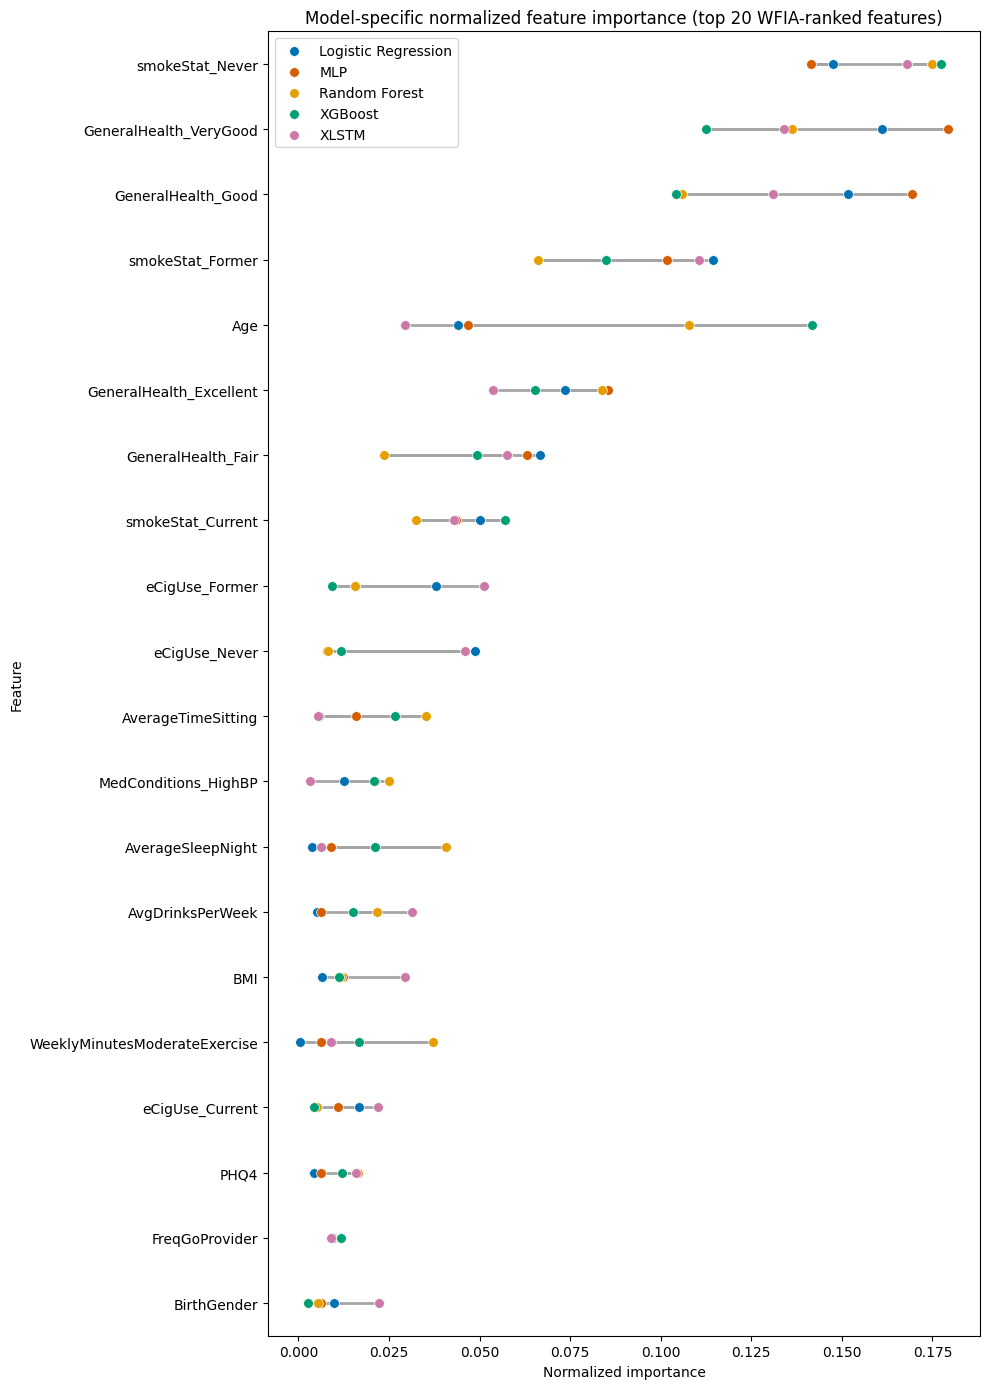

Saved plot to: op/fin_op/feature_importance_differences_top20_noWFIA_thick.png


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Inputs you already have
# -------------------------------------------------------------------
# wfia_df : DataFrame with at least:
#   - 'feature'
#   - 'WFIA_importance' (used ONLY for selecting top-k features)
#   - one column per model: '*_shap_norm'

feature_col = "feature"
top_k = 20  # how many top features to plot

out_dir = "op/fin_op"
os.makedirs(out_dir, exist_ok=True)

# -------------------------------------------------------------------
# 1) Select top-k by WFIA_importance (WFIA NOT plotted)
# -------------------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

shap_norm_cols = sorted([c for c in wfia_top.columns if c.endswith("_shap_norm")])
sources = shap_norm_cols  # ONLY model sources

# -------------------------------------------------------------------
# 2) Labels + colors (WFIA removed)
# -------------------------------------------------------------------
palette = {
    "blue":       "#0072B2",
    "orange":     "#E69F00",
    "teal":       "#009E73",
    "vermillion": "#D55E00",
    "purple":     "#CC79A7",
    "skyblue":    "#56B4E9",
}

legend_labels = {
    "lr_shap_norm":     "Logistic Regression",
    "rf_shap_norm":     "Random Forest",
    "xgb_shap_norm":    "XGBoost",
    "mlp_shap_norm":    "MLP",
    "xlstm_shap_norm":  "XLSTM",
    "tabnet_shap_norm": "TabNet",
}

color_map = {
    "lr_shap_norm":     palette["blue"],
    "rf_shap_norm":     palette["orange"],
    "xgb_shap_norm":    palette["teal"],
    "mlp_shap_norm":    palette["vermillion"],
    "xlstm_shap_norm":  palette["purple"],
    "tabnet_shap_norm": palette["skyblue"],
}

fallback_cmap = plt.get_cmap("tab10")

# -------------------------------------------------------------------
# 3) Prepare
# -------------------------------------------------------------------
features = wfia_top[feature_col].tolist()
n_features = len(features)
y = np.arange(n_features)

plt.figure(figsize=(10, 0.6 * n_features + 2))

# Style knobs you asked for
line_w = 2.0         # thicker connecting line
line_color = "0.65"  # slightly darker gray than before
pt_size = 7          # bigger points (marker size in "s" uses area => s = pt_size^2)

# -------------------------------------------------------------------
# 4) Thick line per feature connecting ONLY model points
# -------------------------------------------------------------------
for i in range(n_features):
    row = wfia_top.iloc[i]
    x_vals = row[sources].to_numpy(dtype=float)
    y_vals = np.full_like(x_vals, fill_value=y[i], dtype=float)

    plt.plot(
        x_vals,
        y_vals,
        color=line_color,
        linewidth=line_w,
        zorder=1,
    )

# -------------------------------------------------------------------
# 5) Bigger model points
# -------------------------------------------------------------------
used_labels = set()

for idx, src in enumerate(sources):
    x_vals = wfia_top[src].to_numpy(dtype=float)
    color = color_map.get(src, fallback_cmap(idx % 10))
    label = legend_labels.get(src, src)

    plot_label = label if label not in used_labels else None
    used_labels.add(label)

    plt.scatter(
        x_vals,
        y,
        color=color,
        s=pt_size**2,   # bigger points
        label=plot_label,
        zorder=2,
        edgecolors="white",
        linewidths=0.5
    )

# -------------------------------------------------------------------
# 6) Axis formatting
# -------------------------------------------------------------------
plt.yticks(y, features)
ax = plt.gca()
ax.set_ylim(n_features - 0.5, -0.5)  # top feature at top
ax.margins(y=0)

plt.xlabel("Normalized importance")
plt.ylabel("Feature")
plt.title(f"Model-specific normalized feature importance (top {n_features} WFIA-ranked features)")
plt.legend(loc="best")
plt.tight_layout()

# -------------------------------------------------------------------
# 7) Save
# -------------------------------------------------------------------
out_path = os.path.join(out_dir, f"feature_importance_differences_top{n_features}_noWFIA_thick.png")
plt.savefig(out_path, dpi=1200, bbox_inches="tight")
plt.show()

print("Saved plot to:", out_path)


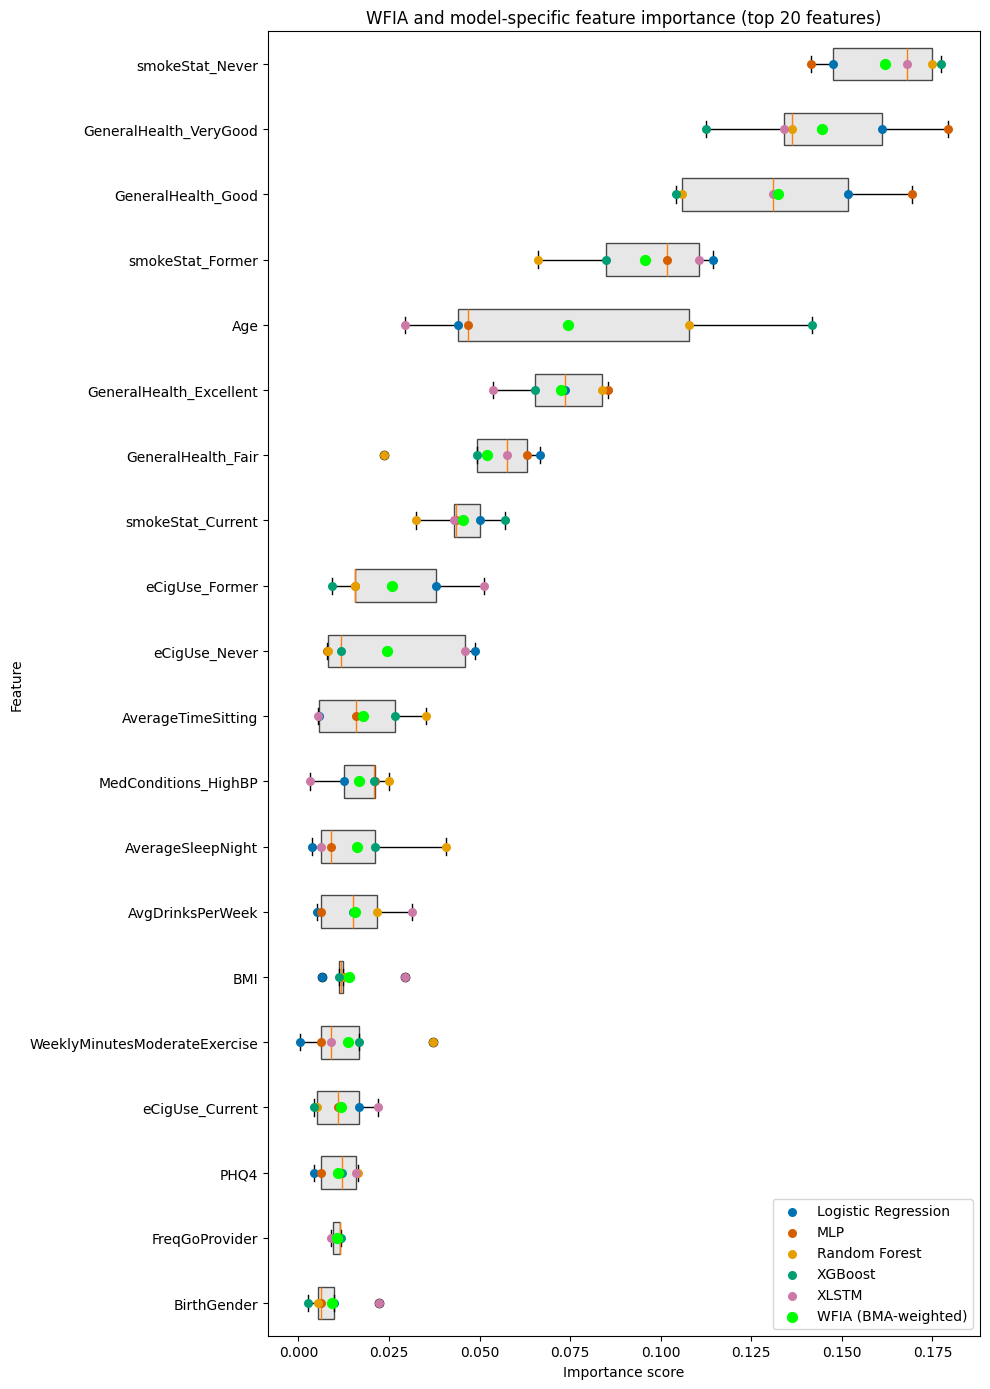

Saved WFIA boxplot to: op/fin_op/wfia_feature_importance_boxplot_top20.png


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Inputs
# ---------------------------------------------------------
feature_col = "feature"
top_k = 20  # how many top features to show

# wfia_df must have at least:
#   - 'feature'
#   - 'WFIA_importance'
#   - per-model columns like 'lr_shap_norm', 'rf_shap_norm', ...

# ---------------------------------------------------------
# 0. Ensure output directory
# ---------------------------------------------------------
out_dir = "op/fin_op"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"wfia_feature_importance_boxplot_top{top_k}.png")

# ---------------------------------------------------------
# 1. Select top-k features by WFIA_importance (highest first)
# ---------------------------------------------------------
wfia_top = (
    wfia_df
    .sort_values("WFIA_importance", ascending=False)
    .head(top_k)
    .copy()
)

# Identify model SHAP columns (e.g., 'lr_shap_norm', 'rf_shap_norm', ...)
shap_norm_cols = [c for c in wfia_top.columns if c.endswith("_shap_norm")]
shap_norm_cols = sorted(shap_norm_cols)  # stable ordering

features = wfia_top[feature_col].tolist()
n_features = len(features)
y_positions = np.arange(n_features)

# ---------------------------------------------------------
# 2. Colors and labels (same as your line plot)
# ---------------------------------------------------------
palette = {
    "blue":         "#0072B2",
    "orange":       "#E69F00",
    "teal":         "#009E73",
    "vermillion":   "#D55E00",
    "purple":       "#CC79A7",
    "yellow":       "#F0E442",
    "skyblue":      "#56B4E9",
    "bright_green": "#00FF00",
}

legend_labels = {
    "lr_shap_norm":     "Logistic Regression",
    "rf_shap_norm":     "Random Forest",
    "xgb_shap_norm":    "XGBoost",
    "mlp_shap_norm":    "MLP",
    "xlstm_shap_norm":  "XLSTM",
    "tabnet_shap_norm": "TabNet",
    "WFIA_importance":  "WFIA (BMA-weighted)",
}

color_map = {
    "lr_shap_norm":     palette["blue"],
    "rf_shap_norm":     palette["orange"],
    "xgb_shap_norm":    palette["teal"],
    "mlp_shap_norm":    palette["vermillion"],
    "xlstm_shap_norm":  palette["purple"],
    "tabnet_shap_norm": palette["skyblue"],
    "WFIA_importance":  palette["bright_green"],
}

fallback_cmap = plt.get_cmap("tab10")

# ---------------------------------------------------------
# 3. Prepare boxplot data (only per-model SHAP, not WFIA)
# ---------------------------------------------------------
box_data = []
for i in range(n_features):
    # values for this feature across models
    vals = wfia_top.iloc[i][shap_norm_cols].values.astype(float)
    box_data.append(vals)

# ---------------------------------------------------------
# 4. Create figure
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 0.6 * n_features + 2))

# Horizontal boxplots: x = importance, y = feature index
bp = ax.boxplot(
    box_data,
    vert=False,
    positions=y_positions,
    patch_artist=True,
    showfliers=True,
    # whis=[0, 100],   # <-- whiskers at min and max
)

# Optional: make boxes light gray
for box in bp["boxes"]:
    box.set_facecolor("#DDDDDD")
    box.set_alpha(0.7)

# ---------------------------------------------------------
# 5. Overlay colored balls for each model and WFIA
# ---------------------------------------------------------
sources = shap_norm_cols + ["WFIA_importance"]

for src_idx, src in enumerate(sources):
    color = color_map.get(src, fallback_cmap(src_idx % 10))
    label = legend_labels.get(src, src)

    # Make WFIA points a bit bigger / prominent
    if src == "WFIA_importance":
        size = 50
        z = 4
    else:
        size = 30
        z = 3

    # Plot one point per feature
    for i in range(n_features):
        x_val = float(wfia_top.iloc[i][src])
        y_val = y_positions[i]
        # Only use label once to avoid duplicates in legend
        if i == 0:
            ax.scatter(x_val, y_val, color=color, s=size, label=label, zorder=z)
        else:
            ax.scatter(x_val, y_val, color=color, s=size, zorder=z)

# ---------------------------------------------------------
# 6. Formatting: features on y-axis, most important at top
# ---------------------------------------------------------
ax.set_yticks(y_positions)
ax.set_yticklabels(features)

# Invert y-axis: most important feature (index 0) at top
ax.set_ylim(n_features - 0.5, -0.5)
ax.margins(y=0)

ax.set_xlabel("Importance score")
ax.set_ylabel("Feature")
ax.set_title(f"WFIA and model-specific feature importance (top {n_features} features)")

# Legend at bottom right
ax.legend(loc="lower right")

plt.tight_layout()

# ---------------------------------------------------------
# 7. Save and show
# ---------------------------------------------------------
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved WFIA boxplot to: {out_path}")
